In [5]:
##SETUP
!pip install nltk;
!pip install geotext;
import nltk;
nltk.download() #this opens an external window that downloads packages in the NLTK library;
                #choose "all" in the first row and press "Download" tp begin
                #close the external window once done to proceed

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [6]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk import RegexpTokenizer
from geotext import GeoText
from nltk.corpus import wordnet as wn
from scipy import stats
from scipy.stats import zscore
import matplotlib.pyplot as plt
import statistics
import numpy as np
import seaborn as sns

headlines = pd.read_excel('NYT Frontpage Headlines Dataset.xlsx')
headlines = headlines.rename(columns={
    "HeadlineType (All Caps, Normal (SentenceCaseNoBold), Bold (SentenceCaseBold))":"HeadlineType",
    "Headline":"HeadlineText",
    "Article text":"ArticlePreview",
    "Article Location":"ArticleLocation"})
headlines['HeadlineText'] = headlines['HeadlineText'].str.lower()
#take to excel to add pronouns -> 
    #headlines are in title case which throws nltk's identifier away 
    #and replacing them thru a list is tedious (as in the code in the addendum)

In [7]:
#########################################################################
#TASK 1: COMPARE FREQ OF PARTS OF SPEECH IN HEADLINES AND PREVIEW TEXT
#########################################################################

headlinesLim = headlines[['HeadlineText','HeadlinePronouns','ArticlePreview']]

#remove manually identified pronouns from headlines for pos_tag
def isNaN(string):
    return string != string

headlineNoPronouns = []

for i in range(headlinesLim.shape[0]):
    headlineText = headlinesLim['HeadlineText'].loc[i]
    pronounsVal = headlinesLim['HeadlinePronouns'].loc[i]
    if isNaN(pronounsVal) == True:
        headlineNoPronouns.append(headlineText)
        continue
    for pronoun in pronounsVal.split(","):
        headlineText = headlineText.replace(pronoun,"").strip()
    headlineNoPronouns.append(headlineText)
headlinesLimClean = pd.concat([headlinesLim,pd.DataFrame(headlineNoPronouns)],axis=1)
headlinesLimClean = headlinesLimClean.rename(columns={0:"HeadlineTextNoPronouns"})

In [8]:
#function for counting the frequency of parts of speech in a given column
def wordFormsFromDFCol(colName,dfName):
    tokenizer = RegexpTokenizer(r'\w+')
    formFreqResults = []
    for i in range(dfName.shape[0]): #rows of df
        formFreq = {}
        #print(dfName[colName])
        for result in nltk.pos_tag(dfName[colName].apply(word_tokenize)[i]): #test on first
            #for the ith row in the df
            key = result[0]
            form = result[1]
            if form in formFreq:
                formFreq[form] += 1
            else:
                formFreq[form] = 1
        #print("----")
        #print(formFreqInHeadline)
        formFreqResults.append(formFreq)
    return formFreqResults

In [9]:
#HEADLINES
#count parts of speech
headlineFormFreqResults = wordFormsFromDFCol("HeadlineTextNoPronouns",headlinesLimClean)
headlinesLimCleanFormCount = pd.concat([headlinesLim,pd.DataFrame(headlineFormFreqResults)],axis=1)
#update value of pronouns using the colum we created
headlinesLimCleanFormCount['NNP'] = headlinesLimCleanFormCount['HeadlinePronouns'].str.split(",").str.len()
headlinesLimCleanFormCount['HeadlineWords'] = headlinesLimCleanFormCount['HeadlineText'].str.split(" ").str.len()
headlinesLimCleanFormCount['ArticlePreviewWords'] = headlinesLimCleanFormCount['ArticlePreview'].str.split(" ").str.len()
headlinesAnalyze = headlinesLimCleanFormCount.drop(['HeadlineText','HeadlinePronouns','ArticlePreview','ArticlePreview','ArticlePreviewWords'],axis=1)
headlineWords = headlinesAnalyze['HeadlineWords'] #keep for graphs
AveragearticlePreviewWords = headlinesLimCleanFormCount['ArticlePreviewWords']
#generate frequencies for each part of speech type
headlinePOSFreq = headlinesAnalyze[headlinesAnalyze.columns.difference(['HeadlineWords'])].div(headlinesAnalyze.HeadlineWords, axis=0)
headlinePOSFreq['Type'] = 'Headline'

In [10]:
#PREVIEW TEXT
#count parts of speech
previewAnalyze = headlinesLimCleanFormCount[['ArticlePreview','ArticlePreviewWords']]
articlePreviewFormResults = wordFormsFromDFCol("ArticlePreview",previewAnalyze)
previewAnalyze = pd.concat([previewAnalyze,pd.DataFrame(articlePreviewFormResults)],axis=1)
previewAnalyze = previewAnalyze.drop(['ArticlePreview'],axis=1)
articlePreviewWords = previewAnalyze['ArticlePreviewWords']
#generate frequencies for each part of speech type
previewTextPOSFreq = previewAnalyze[previewAnalyze.columns.difference(['ArticlePreviewWords'])].div(previewAnalyze.ArticlePreviewWords, axis=0)
previewTextPOSFreq['Type'] = 'Preview Text'

In [11]:
#word count: preview
previewAnalyze['ArticlePreviewWords'].describe()

count     42.000000
mean     239.071429
std       87.157103
min      125.000000
25%      174.500000
50%      223.000000
75%      267.750000
max      498.000000
Name: ArticlePreviewWords, dtype: float64

In [12]:
#calculate z-scores of frequencies for each POS type (for headlines and preview text)
#headlinePOSFreq.loc[:,headlinePOSFreq.columns!='Type'].apply(zscore)
#print(headlinePOSFreq.select_dtypes(include=[np.number]).columns)
#print(headlinePOSFreq.columns)
#stats.zscore(headlinePOSFreq.loc[:,headlinePOSFreq.columns!='Type'],nan_policy='omit')
############
#replace NAs with 0 because NA means that POS does not feature in the text
headlinePOSFreq = headlinePOSFreq.fillna(0)
previewTextPOSFreq = previewTextPOSFreq.fillna(0)
posFreq = pd.concat([headlinePOSFreq,previewTextPOSFreq],axis=0)
#compute z scores
#headlines
#headlinePOSFreqZScores = stats.zscore(headlinePOSFreq.loc[:,headlinePOSFreq.columns!='Type'],nan_policy='omit')
#np.isclose(headlinePOSFreqZScores[','].mean(),0)

In [13]:
headlineFreqSummary = posFreq.query("Type=='Headline'").groupby('Type').mean()
previewTextFreqSummary = posFreq.query("Type=='Preview Text'").groupby('Type').mean()
textFreqSummary = pd.DataFrame.append(headlineFreqSummary,previewTextFreqSummary).T
textFreqSummary['Difference Magnitude'] = textFreqSummary['Headline']/textFreqSummary['Preview Text']
textFreqSummary = textFreqSummary.reset_index().rename(columns={'index':'POS Type'})
posTypeDescription = pd.read_excel('NLKT POS Tag Description.xlsx').rename(columns={'Code':'POS Type','Description':'POS Description'})
textFreqSummary = textFreqSummary.merge(posTypeDescription,on='POS Type')
textFreqSummary = textFreqSummary[['POS Type','POS Description','Headline','Preview Text','Difference Magnitude']]

In [28]:
#run t-tests
posTypes = posFreq.drop(['Type'],axis=1).columns.values
finalResults = dict.fromkeys(posTypes) 
set1 = posFreq[posFreq['Type']=='Headline']
set2 = posFreq[posFreq['Type']=='Preview Text']

for posType in posTypes:
    #test for whether pos_tag mean for headlines == preview text
    twoTailedTest = stats.ttest_ind(set1[posType].dropna(), set2[posType].dropna(), alternative='two-sided')     
    twoTailedTestStatistic = twoTailedTest[0]
    twoTailedTestPVal = twoTailedTest[-1]
    
    #test for whether pos_tag mean for headlines > preview text
    oneTailedTest = stats.ttest_ind(set1[posType].dropna(), set2[posType].dropna(), alternative='greater')
    oneTailedTestPVal = oneTailedTest[-1]
    
    finalResults[posType] = [twoTailedTestStatistic, twoTailedTestPVal, oneTailedTestPVal]    

In [15]:
#plotDF = plotDF.sort_values('Frequency',ascending=False)

In [29]:
testResultSummary = pd.DataFrame(finalResults).T.dropna().reset_index().rename(columns={'index':'POS Type',0:'T-Statistic',1:'P-Value (two-tailed)',2:'P-Value (one-tailed)'})
testResultSummary = testResultSummary.merge(posTypeDescription,on='POS Type')
testResultSummary = testResultSummary[['POS Type','POS Description','T-Statistic','P-Value (two-tailed)','P-Value (one-tailed)']]

In [34]:
testResultSummary.sort_values('P-Value (one-tailed)')
#testResultSummary[testResultSummary['T-Statistic'] > 0].sort_values('P-Value (one-tailed)',ascending=True)
#after replacing NAs with 0s, we have three parts of speech which appear more frequently in headlines versus preview text: 
#1. plural nouns (NNS)
#2. singular nounds (NN)
#3. singular present verbs (VBP)

,POS Type,POS Description,T-Statistic,P-Value (two-tailed),P-Value (one-tailed)
9,NNS,Noun plural ‘desks’,4.586513,1.600512e-05,0.000008
7,NN,"Noun, singular ‘desk’",3.076497,2.846491e-03,0.001423
19,VBP,"Verb, sing. present, non-3d take",1.937297,5.615212e-02,0.028076
13,RBS,"Adverb, superlative best",0.719572,4.738346e-01,0.236917
8,NNP,"Proper noun, singular ‘Harrison’",0.681054,4.977559e-01,0.248878
22,WRB,"Wh-Abverb where, when",0.635650,5.267748e-01,0.263387
15,VB,"Verb, base form take",0.421822,6.742591e-01,0.337130
20,VBZ,"Verb, 3rd person sing. present takes",-0.210031,8.341646e-01,0.582918
6,MD,"Modal could, will",-0.357893,7.213429e-01,0.639329
1,CD,Cardinal digit,-0.427063,6.704529e-01,0.664774


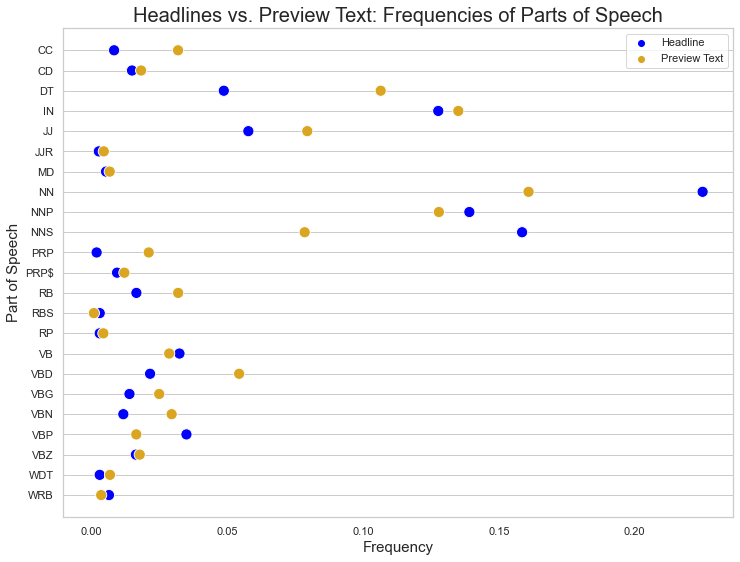

In [31]:
headline = posFreq.groupby('Type').mean().T[['Headline']].rename(columns={'Headline':'Frequency'})
headline['Type'] = 'Headline'
previewText = posFreq.groupby('Type').mean().T[['Preview Text']].rename(columns={'Preview Text':'Frequency'})
previewText['Type'] = 'Preview Text'
result = pd.concat([headline,previewText]).reset_index().rename(columns={'index':'POS Type'})
result = result.merge(posTypeDescription,on='POS Type')
posToDrop = ['$','(',')','EX','FW','JJS','NNPS','PDT','POS','RBR','WP','WP$']
plotDF = result[~result['POS Type'].isin(posToDrop)].rename(columns={'POS Description':'Part of Speech'})
sns.set(rc = {'figure.figsize':(12,9)})
sns.set_theme(style="whitegrid")
sns.set_style({'axes.facecolor':'white'})
scatter = sns.scatterplot(data=plotDF,
                       x="Frequency",
                       y='POS Type',
                       hue='Type',
                       style='Type',
                       s=125,
                       markers=['o', 'o'],
                       #alpha=0.5,
                       palette=['blue','goldenrod'],
                       legend=True)
scatter.legend(loc='upper right')
scatter.grid(axis='x')
scatter.set_xlabel("Frequency",fontsize = 15);
scatter.set_ylabel("Part of Speech",fontsize = 15);
scatter.set_title("Headlines vs. Preview Text: Frequencies of Parts of Speech",fontsize=20);

In [349]:
#########################################################################
#TASK 2: COMPARE FREQ OF HYPERNYMS & HYPONYMS IN HEADLINES AND PREVIEW TEXT
#########################################################################

pt2Headlines = headlinesLimClean[['HeadlineText']]
pt2PreviewText = headlinesLimClean[['ArticlePreview']]

#test headline -> hyponyms (H0: more base words so should feature more hyponyms)
headlineMeanHyponyms = []
headlineMeanHypernyms = []
for i in range(42):
    hyponymCountHeadline = []
    hypernymCountHeadline = []
    for word in pt2Headlines.loc[i].values[0].split(" "):
        for ss in wn.synsets(word):
            hyponymCountHeadline.append(len(ss.hyponyms()))
            hypernymCountHeadline.append(len(ss.hypernyms()))
    headlineMeanHyponyms.append(statistics.mean(hyponymCountHeadline))
    headlineMeanHypernyms.append(statistics.mean(hypernymCountHeadline))

In [350]:
print("**Headlines:**")
print("Hyponyms (mean):",statistics.mean(headlineMeanHyponyms))
print("Hyponyms (s.d):",statistics.stdev(headlineMeanHyponyms))
print("\nHypernyms (mean):",statistics.mean(headlineMeanHypernyms))
print("Hypernyms (s.d):",statistics.stdev(headlineMeanHypernyms))

**Headlines:**
Hyponyms (mean): 2.454842627359863
Hyponyms (s.d): 1.632493378200929

Hypernyms (mean): 0.7685536212748706
Hypernyms (s.d): 0.12826475342355198


In [351]:
#test preview text -> hyponyms (H0: fewer base words so should feature less hyponyms)
previewMeanHyponyms = []
previewMeanHypernyms = []
for i in range(42):
    hyponymCountPreview = []
    hypernymCountPreview = []
    for word in pt2PreviewText.loc[i].values[0].split(" "):
        for ss in wn.synsets(word):
            hyponymCountPreview.append(len(ss.hyponyms()))
            hypernymCountPreview.append(len(ss.hypernyms()))
    previewMeanHyponyms.append(statistics.mean(hyponymCountPreview))
    previewMeanHypernyms.append(statistics.mean(hypernymCountPreview))

In [352]:
print("**Preview Text:**")
print("Hyponyms (mean):",statistics.mean(previewMeanHyponyms))
print("Hyponyms (s.d):",statistics.stdev(previewMeanHyponyms))
print("\nHypernyms (mean):",statistics.mean(previewMeanHypernyms))
print("Hypernyms (s.d):",statistics.stdev(previewMeanHypernyms))

**Preview Text:**
Hyponyms (mean): 3.31403740638585
Hyponyms (s.d): 0.45935347505827123

Hypernyms (mean): 0.6765941701838908
Hypernyms (s.d): 0.03783530995015731


In [353]:
#T-TEST (h0: mean no. of hyponyms for headlines > preview text)
numerator = (statistics.mean(headlineMeanHyponyms)-statistics.mean(previewMeanHyponyms))
denominator = ((statistics.stdev(headlineMeanHyponyms)**2)/42)+(statistics.stdev(previewMeanHypernyms)**2/42)
hyponymTTestVal = numerator/denominator
hyponymTTestVal #p-val < 0.05; reject the null; hyponynms in headline !> those in preview text

-13.533335439865342

In [354]:
nltk.pos_tag(["Supreme","Court","lets","Texas","law","be","challenged"])

[('Supreme', 'NNP'),
 ('Court', 'NNP'),
 ('lets', 'VBZ'),
 ('Texas', 'NNP'),
 ('law', 'NN'),
 ('be', 'VB'),
 ('challenged', 'VBN')]

In [355]:
###############
###ADDENDUM
###############
# #count number of manually identified pronouns in the headline column
# headlines['PronounNum'] = 0
# headlines['HeadlineTextNoPronoun'] = headlines['HeadlineText']
# for i in range(headlines.shape[0]):
#     headlineText = headlines['HeadlineText'].loc[i] 
#     for pronoun in headlinePronouns:
#         pronounSearch = pronoun.lower()
#         if pronounSearch in headlineText:
#             #count the number of pronouns
#             headlines['PronounNum'].loc[headlines['HeadlineText']==headlineText] += 1
#             #remove these pronouns from the headline column to run through the NLKT's pos_tagger
#             headlines['HeadlineTextNoPronoun'].loc[headlines['HeadlineText']==headlineText] = headlines['HeadlineText'].str.replace(headlinePronouns,"")

In [356]:
print("Avg. words:")
print("Headline:",headlineWords.mean())
print("Preview text:",AveragearticlePreviewWords.mean())

Avg. words:
Headline: 8.30952380952381
Preview text: 239.07142857142858
